# Code for Batch Trajectory Alignment and Similarity Metrics

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from ipywidgets import *

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [7]:
from nah.loader import load_raw_csv_data, load_npzs
from nah.utils import norm_data, full_align,clean_rot_data, segment_by_demo, sum_of_squares
from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_heatmap, plot_correlation_matrix
from nah.datagraphs import generate_self_similarity_heat_map, hand_range, study_range_vals, generate_all_cross_correlation_matrix, generate_pairwise_comparison

from evo.core.trajectory import PoseTrajectory3D
from nah.trajectory import get_evo_trajectory, get_evo_metrics, evo_sync, convert_evo_to_np, evaluate_ape
from nah.alignments import evo_align, Alignment

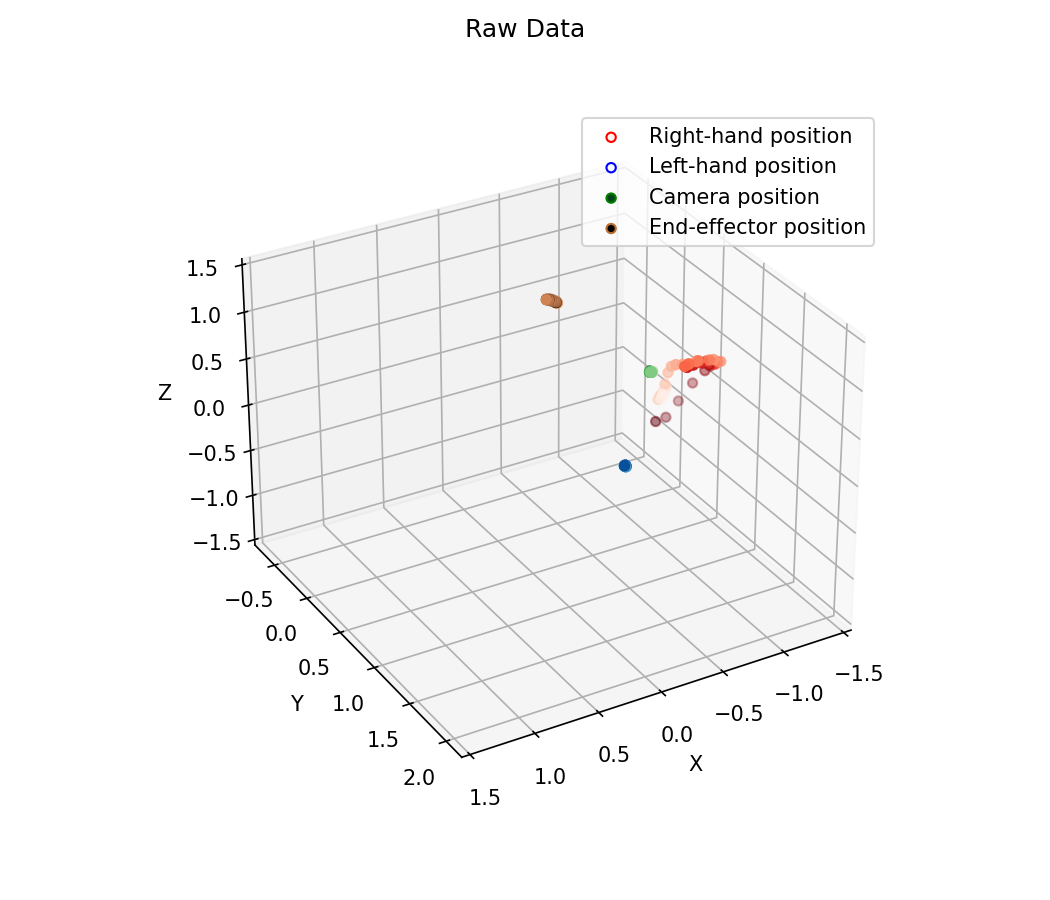

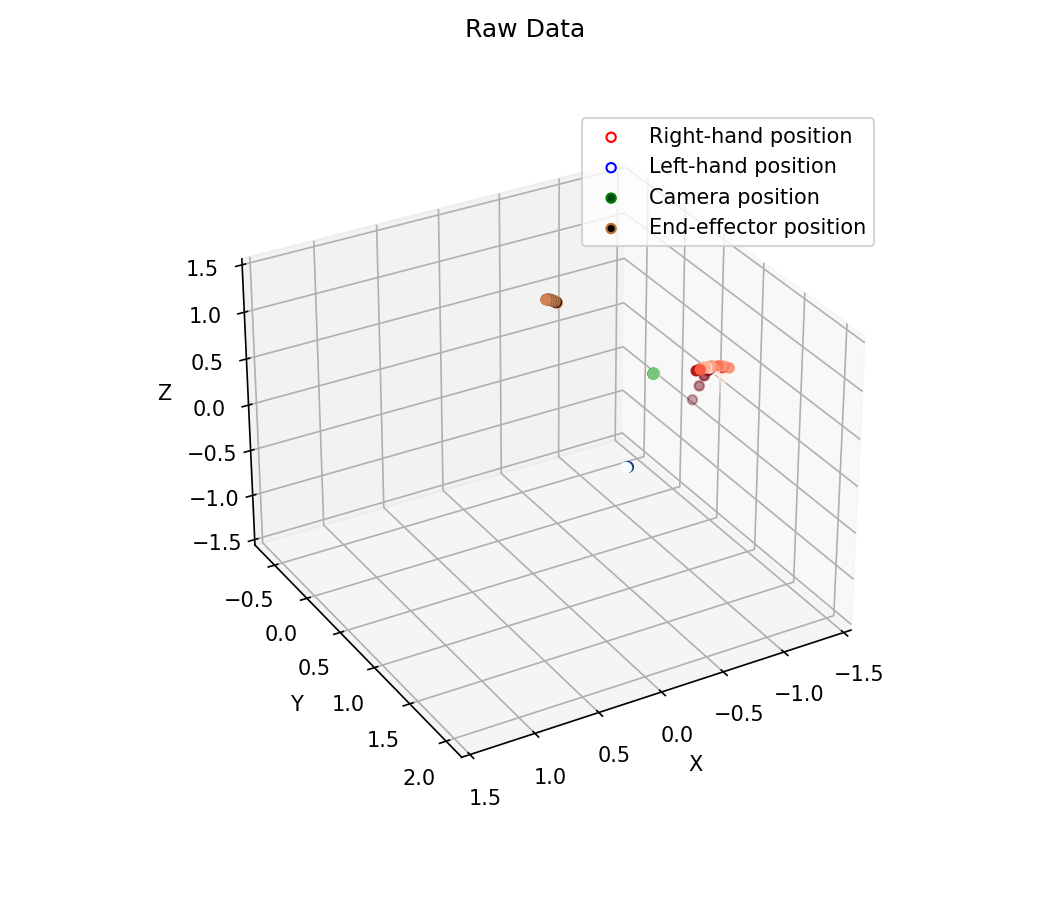

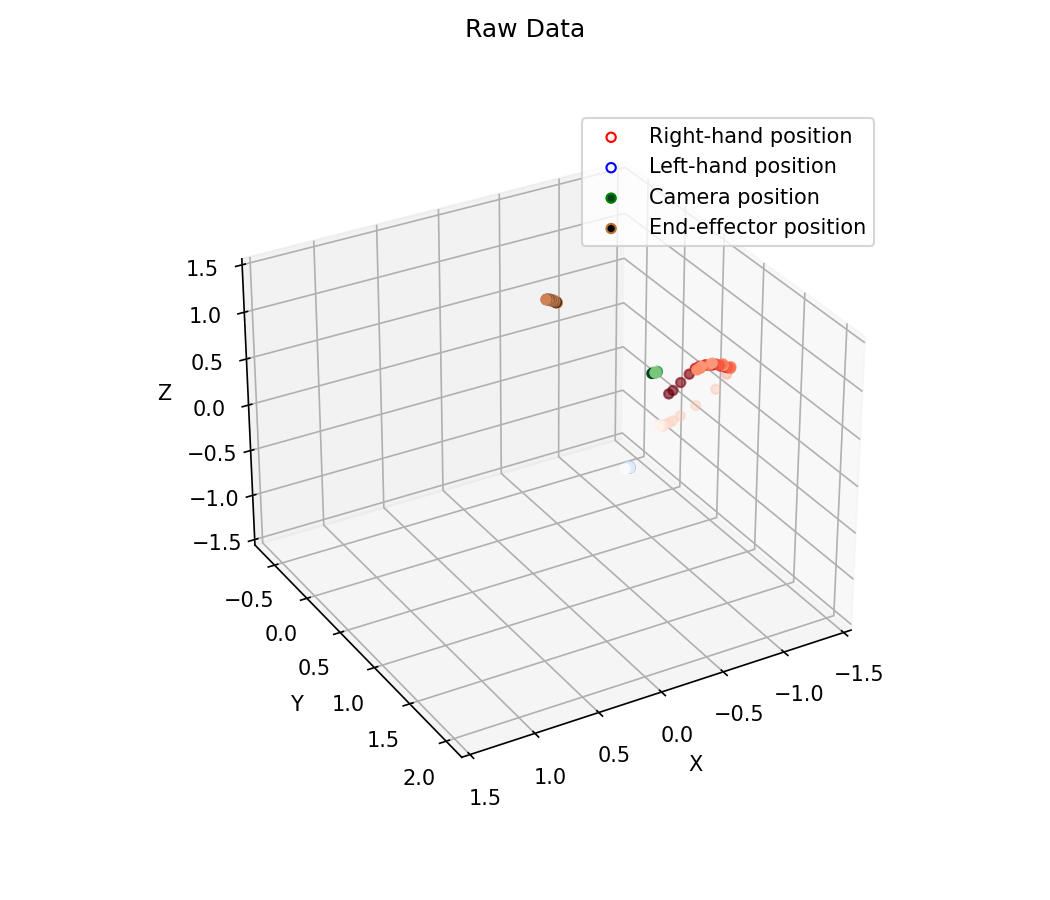

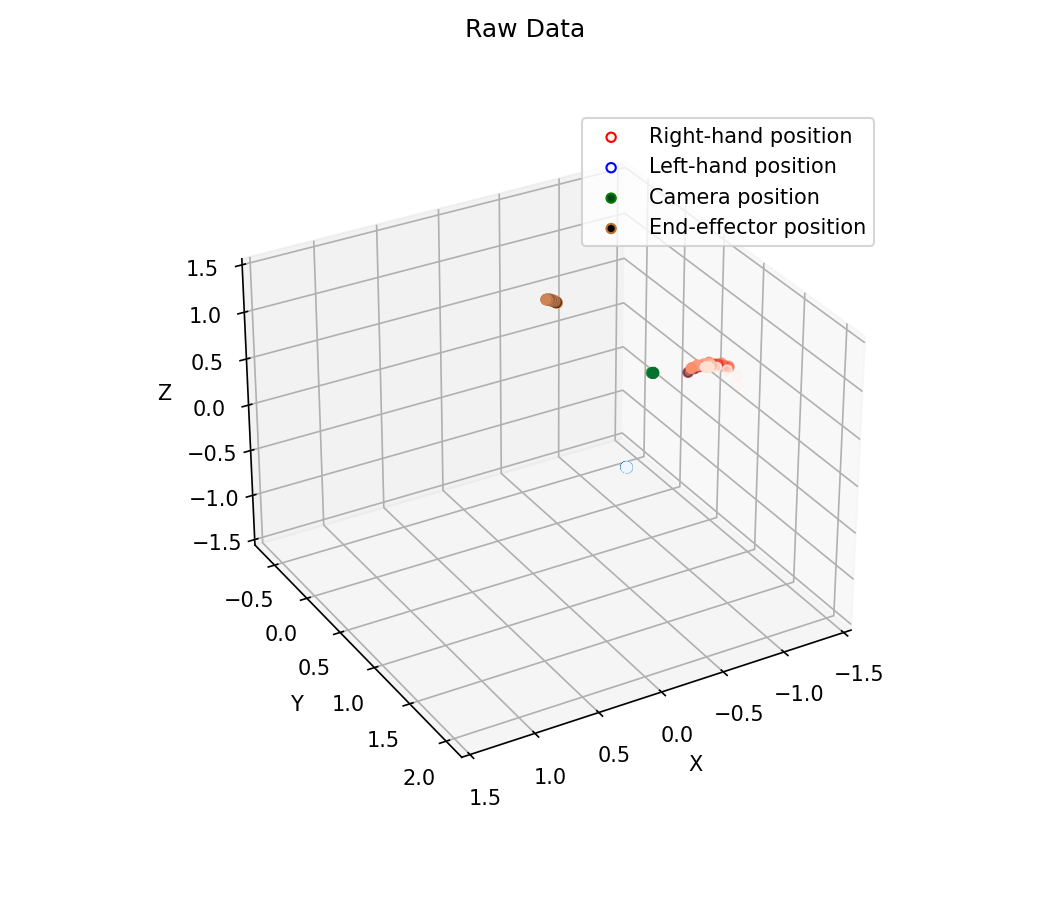

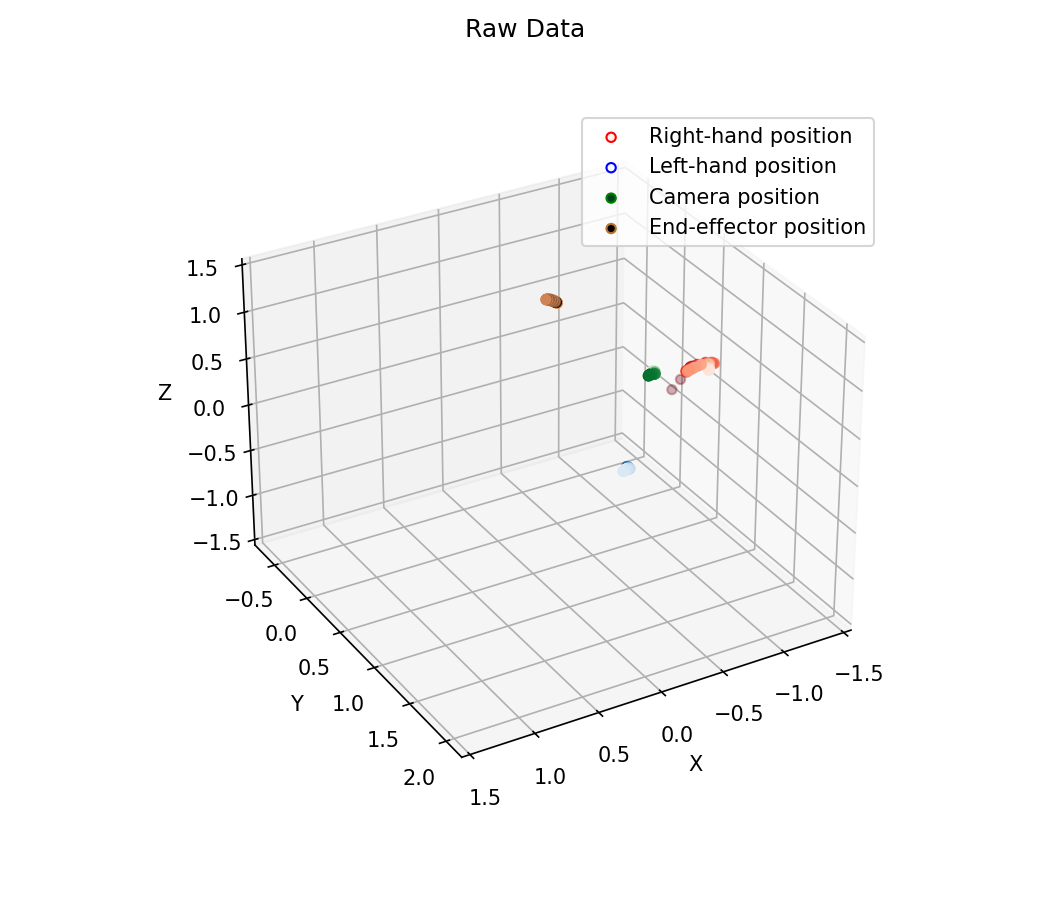

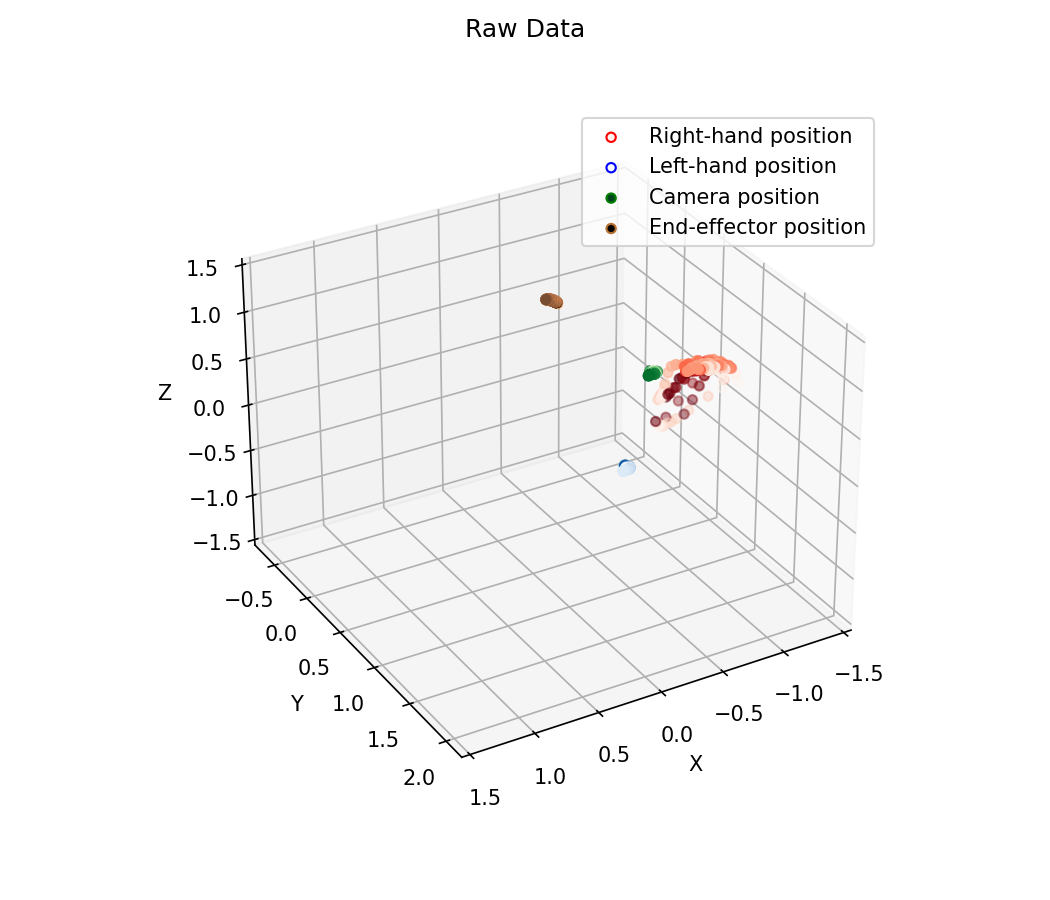

In [14]:
%matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook

# robot_name='j2s6s300'
robot_name='Reachy'
gesture_num=1


total_end_eff = np.array([])
total_camera  = np.array([])
total_rh      = np.array([])
total_lh      = np.array([])
total_joint   = np.array([])

singlePID=True
singlePIDval = 7
followup = True

if singlePID:
    PID_begin_range=singlePIDval
    PID_end_range=singlePIDval+1 #Don't forget to +1 to whatever your last PID is
else:
    PID_begin_range=1
    if followup:
        PID_end_range=10 #Don't forget to +1 to whatever your last PID is
    else:
        PID_end_range=17
for PID in range(PID_begin_range,PID_end_range):
    end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)
    if (PID==PID_begin_range):
        total_end_eff = end_eff
        total_camera = camera
        total_rh = rh
        total_lh = lh
        total_joint = joint
    else:
        total_end_eff = np.vstack((total_end_eff,end_eff))
        total_camera  = np.vstack((total_camera,camera))
        total_rh      = np.vstack((total_rh,rh))
        total_lh      = np.vstack((total_lh,lh))
        total_joint   = np.vstack((total_joint,joint))

# plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

demo_max=5
end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
for i in range(0,5):
    plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

plot_raw_data(5, total_end_eff, total_camera, total_rh, total_lh, total_joint)

Right hand range:0.8500059763056297
Left hand range:0.08426110137044254
Camera range:0.048635552726374875
Right hand range:0.8088668657341824
Left hand range:0.09001172821166141
Camera range:0.034044721206084254
Right hand range:0.6369223608824233
Left hand range:0.09896899522224113
Camera range:0.029836401647148993
Right hand range:0.19759494479221884
Left hand range:0.06139179344676292
Camera range:0.024984873511987287
Right hand range:0.29726533649453657
Left hand range:0.07473482293924287
Camera range:0.0946723129560063
Centering data for participant 1 gesture 5
Centering data for participant 1 gesture 5
Right hand range:0.2659537621302808
Left hand range:0.12102093982683321
Camera range:0.030399003058653035
Right hand range:0.6693348848224556
Left hand range:0.08578410018534897
Camera range:0.05569409910897202
Right hand range:0.8915826918624579
Left hand range:0.08844392605854853
Camera range:0.0653856261497892
Right hand range:0.9845629214902876
Left hand range:0.194671717146816

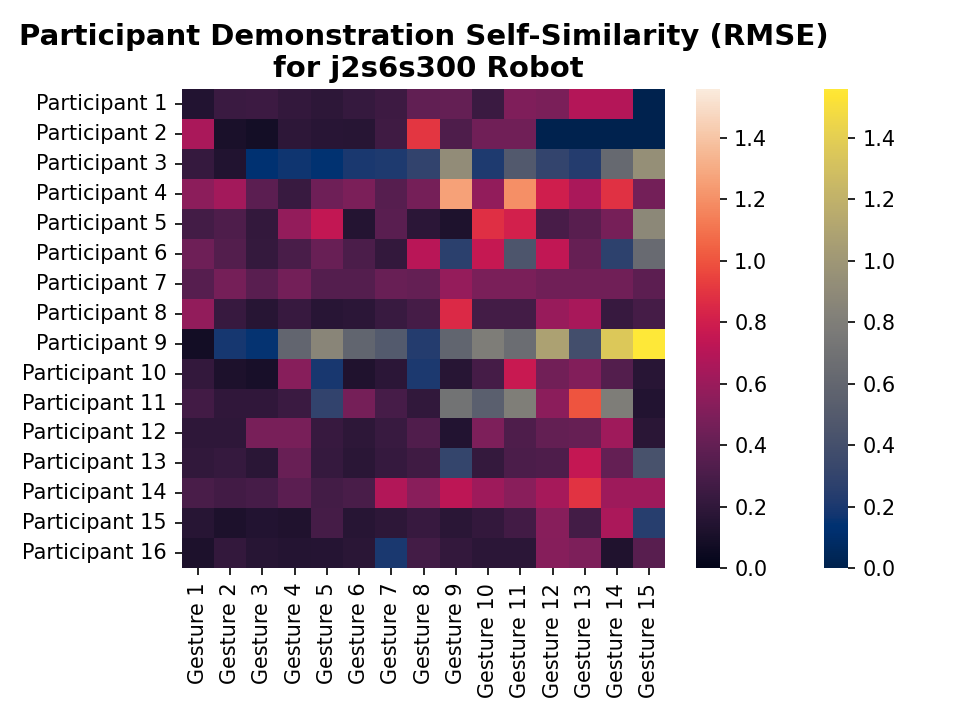

In [19]:
plt.close("all")

robot_name = "j2s6s300"
# robot_name = "Reachy"

followup = False
demo_max = 5

demo_heatmap_array, handed_array = generate_self_similarity_heat_map(robot_name,followup, demo_max)
plt.close("all")
plot_heatmap(robot_name, followup, demo_heatmap_array, handed_array)


In [3]:
"""Cross-correlation matrix:

Generate one cross-correlation graph per gesture, per robot, comparing all participants to each other.
Each participant does 5 demos, so that means 5x5 pairwise demo comparisons. Average the RMSE (should 
be legitimate; the lengths of the trajectories are almost the same). Each pairwise comparison of demos 
needs to be both temporally and spatially aligned. (Other analyses with only temporal or only spatial
alignment are also interesting, showing where participants chose similar motions with different rates
of speed, or similar motions but with different levels of enthusiasm. But for now, do all of it. The
order of operations is as follows:

1) For each robot and gesture, load two participants (go through all pairs)
2) For each pair, go through all pairs of demos
3) Figure out which hand is being used. Compare only the active hands. Make a matrix of which hand is
   being used so that we can color-code this in the final plot.
4) For that hand (for each participant), align the trajectories, first spatially (with evo), then 
   temporally (with DTW)
5) Compute the similarity between demos with APE (perhaps with translation scaling, or translation 
    only?)
6) Save this into the appropriate entry in a matrix so this can be turned into a heat map with seaborn
"""
# robot_name = "j2s6s300"
robot_name = "Reachy"
followup=False
demo_max = 5
gesture = 1
participant_1 = 12
participant_2 = 13

temp_metric, is_right_hand = generate_pairwise_comparison(participant_1, participant_2,robot_name, gesture, followup, demo_max, alignment=Alignment.SpatioTemporal)
# correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max)
# plot_heatmap(robot_name, followup, correlation_array, hand_array)                
print(temp_metric)
print(is_right_hand)


Comparing demos 1 and 1
get_evo_metrics_succeeded on try 1
Comparing demos 1 and 2
get_evo_metrics_succeeded on try 1
Comparing demos 1 and 3
get_evo_metrics_succeeded on try 1
Comparing demos 1 and 4
get_evo_metrics_succeeded on try 1
Comparing demos 1 and 5
get_evo_metrics_succeeded on try 1
Comparing demos 2 and 1
get_evo_metrics_succeeded on try 1
Comparing demos 2 and 2
get_evo_metrics_succeeded on try 1
Comparing demos 2 and 3
get_evo_metrics_succeeded on try 1
Comparing demos 2 and 4
get_evo_metrics_succeeded on try 1
Comparing demos 2 and 5
get_evo_metrics_succeeded on try 1
Comparing demos 3 and 1
get_evo_metrics_succeeded on try 1
Comparing demos 3 and 2
get_evo_metrics_succeeded on try 1
Comparing demos 3 and 3
get_evo_metrics_succeeded on try 1
Comparing demos 3 and 4
get_evo_metrics_succeeded on try 1
Comparing demos 3 and 5
get_evo_metrics_succeeded on try 1
Comparing demos 4 and 1
get_evo_metrics_succeeded on try 1
Comparing demos 4 and 2
get_evo_metrics_succeeded on try

In [4]:
print(temp_metric)
print(is_right_hand)

0.897217338382969
True


In [4]:
# robot_name = "j2s6s300"
robot_name = "Reachy"
followup=False
demo_max = 5
gesture = 1
# participant_1 = 12
# participant_2 = 13


In [ ]:
correlation_array, hand_array =generate_all_cross_correlation_matrix(robot_name, gesture, followup, demo_max)
# plot_heatmap(robot_name, followup, correlation_array, hand_array)

In [8]:
%matplotlib widget
filename = "Reachy_gesture_1_cross_correlation.npz"
data = np.load(filename)
correlation_array = data['correlation_array']
hand_array = data['hand_array']
plot_correlation_matrix(robot_name, gesture, followup, correlation_array, hand_array)


TypeError: plot_correlation_matrix() missing 1 required positional argument: 'handed_array'

In [7]:
np.savez(str(robot_name)+"_gesture_"+str(gesture)+"_cross_correlation",correlation_array=correlation_array, hand_array=hand_array)


In [ ]:
## Comparison between RH and robot end-eff
# (We'll want comparisons between the person's different demos, and the end-eff and the lh, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15

for singlePIDval in range(1,PID_max+1):
    for gesture_num in range(1,gesture_max+1):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        demo_max=5
        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        for demo_num in range(0,5):
            end_eff_traj = get_evo_trajectory(end_eff[i])
            right_hand_traj = get_evo_trajectory(rh[i])   

            end_eff_traj, right_hand_traj = evo_sync(end_eff_traj, right_hand_traj)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            print(metric.get_all_statistics()) # Not aligned statistics
            
            right_hand_traj = align(right_hand_traj, end_eff_traj)

            end_eff_aligned = convert_evo_to_np(end_eff_traj, end_eff[i].shape)
            # print(end_eff_aligned.shape)
            
            rh_aligned = convert_evo_to_np(right_hand_traj, rh[i].shape)
            # print(rh_aligned.shape)

            metric = evaluate_ape(end_eff_traj, right_hand_traj)
            metric.get_all_statistics() #Aligned statistics

In [ ]:
## Comparison between RH demos
# (We'll want comparisons between the person's different demos (both RH and LH, depending), and the end-eff and the hands, also)

# robot_name='j2s6s300'
robot_name='Reachy'

followup = False
demo_max = 5

if followup:
    PID_max = 9
    gesture_max = 6
else: 
    PID_max = 16
    gesture_max = 15


for singlePIDval in range(1,PID_max+1):
# for singlePIDval in range(1,2):    
    for gesture_num in range(1,gesture_max+1):
    # for gesture_num in range(1,2):
        end_eff, camera, rh, lh, joint = load_npzs(robot_name, PID, followup, gesture_num)

        end_eff, camera, rh, lh, joints = segment_by_demo(total_end_eff, total_camera, total_rh, total_lh, total_joint, demo_max)
        # for i in range(0,5):
        #     plot_raw_data(5, end_eff[i], camera[i], rh[i], lh[i], joint[i])

        demo_similarity = np.zeros([4,4,3])

        print("PID "+str(singlePIDval)+", gesture "+str(gesture_num))
        for demo_num1 in range(0,demo_max-1):
            for demo_num2 in range(demo_num1+1,demo_max):
                # print("PID "+str(singlePIDval)+", gesture "+str(gesture_num)+", demos "+str(demo_num1)+","+str(demo_num2))
                metrics1 = get_evo_metrics(rh[demo_num1],rh[demo_num2])
                # metrics2 = get_evo_metrics(rh[demo_num1],rh[demo_num2], alignment=Alignment.Spatial)
                # print(metrics1)
                # print(metrics1,metrics2)

                demo_similarity[demo_num1][demo_num2-1][0] = metrics1['rmse']
                demo_similarity[demo_num1][demo_num2-1][1] = metrics1['mean']
                demo_similarity[demo_num1][demo_num2-1][2] = metrics1['std']

        print(demo_similarity)

In [ ]:
end_eff_aligned = convert_evo_to_np(end_eff_traj)
print(end_eff_aligned.shape)

rh_aligned = convert_evo_to_np(right_hand_traj)
print(rh_aligned.shape)

In [ ]:
# Plot both trajectories on top of each other after alignment:
plot_raw_data(5, end_eff_aligned, camera[0], rh_aligned, lh[0], joint[0])

In [ ]:
metric = evaluate_ape(end_eff_traj, right_hand_traj)
metric.get_all_statistics()